In [1]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# # Now you can access files and folders in Google Drive via the /content/drive path
# folder_path = '/content/drive/MyDrive/All Projects/Saffron Project - BTP/CNN Image Data'  # Replace with your folder path in Google Drive

In [4]:
folder_path = 'data/image_data'

In [3]:
# NumPy: Fundamental library for numerical operations with support for large arrays and matrices.
import numpy as np

# Pandas: Powerful data manipulation and analysis library with Series and DataFrame data structures.
import pandas as pd

# TensorFlow: Open-source machine learning library for building, training, and deploying models.
import tensorflow as tf

# Matplotlib: Widely-used plotting library in Python for creating diverse visualizations.
import matplotlib.pyplot as plt

# Keras: High-level neural networks API running on top of TensorFlow for easy model development.
from keras import layers, Sequential, models


print("All libraries succesfully installed and loaded !!")

All libraries succesfully installed and loaded !!


In [5]:
# Set the batch size for training data.
BATCH_SIZE = 8

# Define the image size for preprocessing and model input.
IMAGE_SIZE = 180

# Specify the number of channels in the images (3 for RGB).
CHANNELS = 3

print("Batch size, Image size, channels and epochs INITIALIZED !!!!")

Batch size, Image size, channels and epochs INITIALIZED !!!!


In [6]:
# Create a TensorFlow dataset from images stored in the specified directory.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    seed=12,  # Set a seed for reproducibility.
    shuffle=True,  # Shuffle the dataset for better training performance.
    image_size = (IMAGE_SIZE, IMAGE_SIZE),  # Resize images to the specified dimensions.
    batch_size = BATCH_SIZE  # Set the batch size for training the model.
)
print("tensorflow dataset created")

Found 500 files belonging to 5 classes.
tensorflow dataset created


In [7]:
class_names = dataset.class_names
print("The dataset consists of classes:",class_names)

The dataset consists of classes: ['C1', 'C2', 'C3', 'C4', 'C5']


In [8]:
len(dataset)

63

In [9]:
#image specifications
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)

(8, 180, 180, 3)


In [8]:
# labels = [0]*100+[1]*100+[2]*100+[3]*100+[4]*100

In [10]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
for image_batch, labels_batch in dataset.take(1):
  print(labels_batch.numpy())

[2 3 0 3 3 4 3 1]


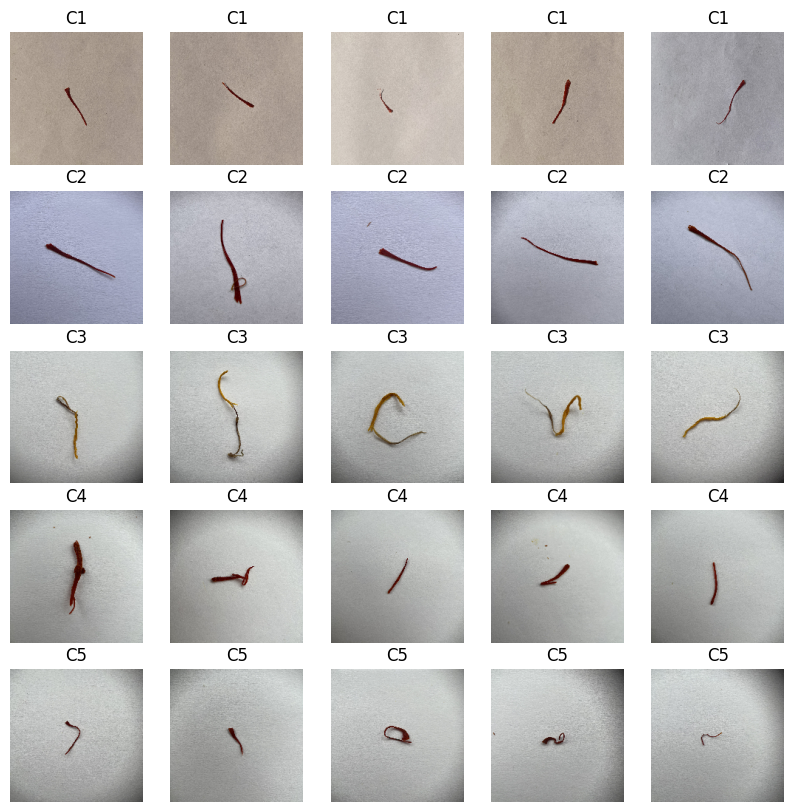

In [12]:
import matplotlib.pyplot as plt

# Prepare to visualize the images
plt.figure(figsize=(10, 10))

# Create a dictionary to count the number of images per class
class_image_count = {class_name: 0 for class_name in class_names}

# This variable will help in plotting 25 images
total_images = 25

# Go through the dataset and plot images
for image_batch, label_batch in dataset:
    for img, label in zip(image_batch, label_batch):
        class_name = class_names[label]
        # Check if we still need more images for this class
        if class_image_count[class_name] < 5:
            # Calculate the correct position index for the subplot
            position_index = class_names.index(class_name) * 5 + class_image_count[class_name] + 1

            # Plot the image
            ax = plt.subplot(5, 5, position_index)
            plt.imshow(img.numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")  # Turn off axis numbers and ticks

            # Increment the count for the current class
            class_image_count[class_name] += 1

        # Stop if we've collected enough images
        if sum(class_image_count.values()) >= total_images:
            break
    # Exit the outer loop as well if we got all the images we needed
    if sum(class_image_count.values()) >= total_images:
        break

# Display the plot
plt.show()

In [13]:
#set the train, validation and test splits in decimals , example 80 % as 0.8.
#NOTE: the total train + val + test should be equal to  1

def get_dataset_partitions_tf(ds, train_split=0.8 , val_split=0.1, test_split=0.1 , shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print("Size of Data is: {0}\nBatch size of Training Data is: {1}\nBatch size of Validation Data is: {2}\nBatch size of Test Data is: {3}".format(
    len(dataset),
    len(train_ds),
    len(val_ds),
    len(test_ds)
))

Size of Data is: 63
Batch size of Training Data is: 50
Batch size of Validation Data is: 6
Batch size of Test Data is: 7


In [14]:
# Cache the training dataset in memory for faster access during training.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Cache the validation dataset in memory for faster access during model evaluation.
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Cache the test dataset in memory for faster access during model testing.
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [15]:
# Sequential model for resizing images to IMAGE_SIZE and rescaling pixel values
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [21]:
!pip install --upgrade tensorflow
!pip install tensorflow-addons==0.19.0 # Install a compatible version

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

# Gaussian noise layer
class GaussianNoiseLayer(layers.Layer):
    def __init__(self, mean=0.0, stddev=0.02, **kwargs):
        super().__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
        return inputs + noise

# Speckle noise layer
class SpeckleNoiseLayer(layers.Layer):
    def __init__(self, stddev=0.02, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
        return inputs + inputs * noise

# Impulse noise layer
class ImpulseNoiseLayer(layers.Layer):
    def __init__(self, density=0.02, **kwargs):
        super().__init__(**kwargs)
        self.density = density

    def call(self, inputs):
        mask = tf.random.uniform(shape=tf.shape(inputs)) < self.density
        salt_pepper_noise = tf.where(mask, tf.random.uniform(shape=tf.shape(inputs)), inputs)
        return salt_pepper_noise

# Sequential model for data augmentation with additional noise layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),

    GaussianNoiseLayer(stddev=0.02),
    SpeckleNoiseLayer(stddev=0.02),
    ImpulseNoiseLayer(density=0.02),
])

# Assuming train_ds is your training dataset, apply data augmentation
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
#  # Sequential model for data augmentation, including random horizontal and vertical flips, and random rotation
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
# ])

# # Applying data augmentation to the training dataset using the map function and prefetching for performance
# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
# CNN Model Architecture
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    data_augmentation,
    layers.Conv2D(16, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# model.build(input_shape=input_shape)

print("CNN architecture has been built sucessfully !")

CNN architecture has been built sucessfully !


In [23]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,373 (6.34 MB)

 Trainable params: 1,662,373 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Installing the Library required for visualization as this library is not installed in colab
# For this Python PIP is used.
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 19.3 MB/s eta 0:00:00


C:\Users\HP\Desktop\ProjectFiles\Image_Classification\venv\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


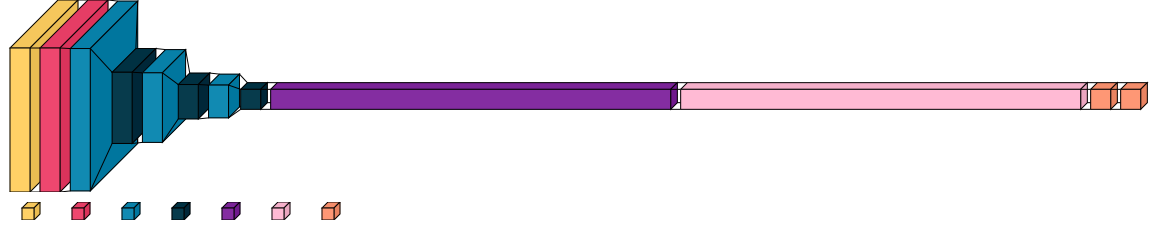

In [24]:
# After installation of library, now it canbbe imported
import visualkeras
visualkeras.layered_view(model, legend=True, scale_xy=0.8)

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
print("Model sucessfully Comppiled!")

Model sucessfully Comppiled!


In [26]:
#code to check availability of GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


In [27]:
#Model training using the compiled model
# Set the number of epochs for training the model.
EPOCHS = 25

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

print("Model successfuly trained")

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 715ms/step - accuracy: 0.1931 - loss: 1.7679 - val_accuracy: 0.2500 - val_loss: 1.5414
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - accuracy: 0.2765 - loss: 1.5342 - val_accuracy: 0.3125 - val_loss: 1.4549
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.3437 - loss: 1.4051 - val_accuracy: 0.7292 - val_loss: 1.1505
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 232ms/step - accuracy: 0.5361 - loss: 1.1878 - val_accuracy: 0.6875 - val_loss: 0.8006
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - accuracy: 0.7063 - loss: 0.8791 - val_accuracy: 0.3542 - val_loss: 1.4418
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.7144 - loss: 0.7595 - val_accuracy: 0.6250 - val_loss: 0.8115
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 232ms/step - accuracy: 0.6537 - loss: 0.9113 - val_accuracy: 0.8750 - val_loss: 0.5072
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 228ms/step - accuracy: 0.7440 - loss: 0.6471 - val_accu

In [28]:
scores = model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.8965 - loss: 0.2540


In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

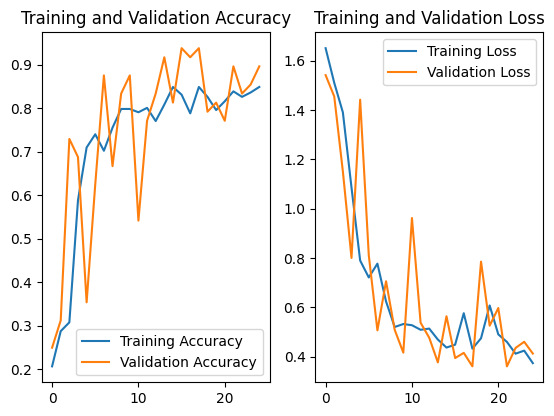

In [30]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (10,10))
plt.subplot(2,3,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,3,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

In [31]:
import numpy as np

lbls_true = []
lbls_pred = []  # predicted integer labels
pred_confs = []  # confidences

for imgs, lbls in test_ds:
    lbls_true.extend(lbls.numpy().tolist())

    pred_imgs = model.predict(imgs)
    for pred_img in pred_imgs:
        lbls_pred.append(np.argmax(pred_img))
        pred_confs.append(np.max(pred_img))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


In [33]:
from sklearn.metrics import confusion_matrix

# changing integer labels to class names
lbls_true_names = list(map(lambda x: class_names[x], lbls_true))
lbls_pred_names = list(map(lambda x: class_names[x], lbls_pred))

# getting confusion matrix
cf_matrix = confusion_matrix(lbls_true_names, lbls_pred_names, labels=class_names)
cf_matrix_title = 'Confusion Matrix using Test Set'
print(cf_matrix_title)
print(cf_matrix)

Confusion Matrix using Test Set
[[ 9  0  0  0  3]
 [ 0  9  0  2  0]
 [ 0  0 15  0  0]
 [ 0  1  0  9  1]
 [ 0  1  0  1  5]]


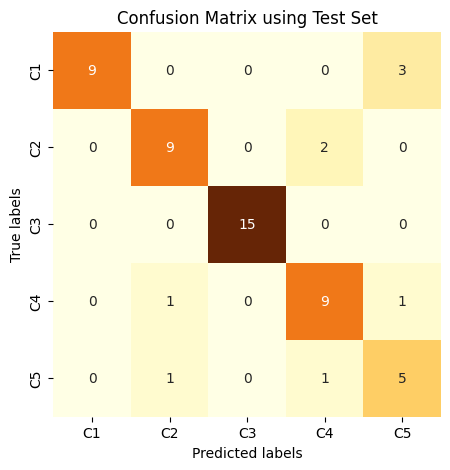

In [34]:
import seaborn as sns

#plotting confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cf_matrix, annot=True, fmt='g',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, cmap='YlOrBr')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(cf_matrix_title)
plt.show()


In [35]:
# getting precisions
pred_sums = np.sum(cf_matrix, axis=0)
prec_matrix = cf_matrix / pred_sums
precs = prec_matrix.diagonal()

# getting recalls
true_sums = np.sum(cf_matrix, axis=1)
recall_matrix = cf_matrix / true_sums
recalls = recall_matrix.diagonal()

# getting f1 measures
f1s = (2 * precs * recalls) / (precs + recalls)

In [36]:
# displaying evaluations
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s},
                        index=class_names)
pd.options.display.float_format = '{:.2%}'.format
evals_df

,Precision,Recall,F1
C1,100.00%,75.00%,85.71%
C2,81.82%,81.82%,81.82%
C3,100.00%,100.00%,100.00%
C4,75.00%,81.82%,78.26%
C5,55.56%,71.43%,62.50%


In [38]:
# Save the model to a file
model.save('saffron_model_v1.keras')  # You can replace 'potato_disease_model_v1.h5' with your desired file name

In [ ]:
# Optionally, download the saved model file to your local machine
from google.colab import files
files.download('saffron_model_v1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

first image to predict
actual label: C3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
predicted label: C3


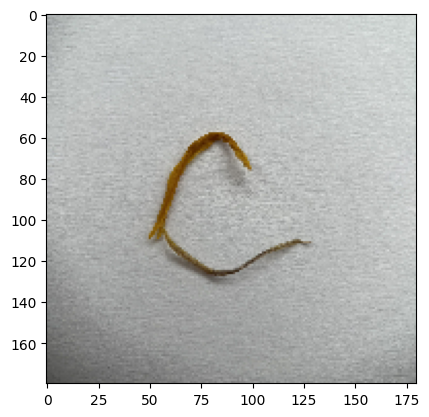

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


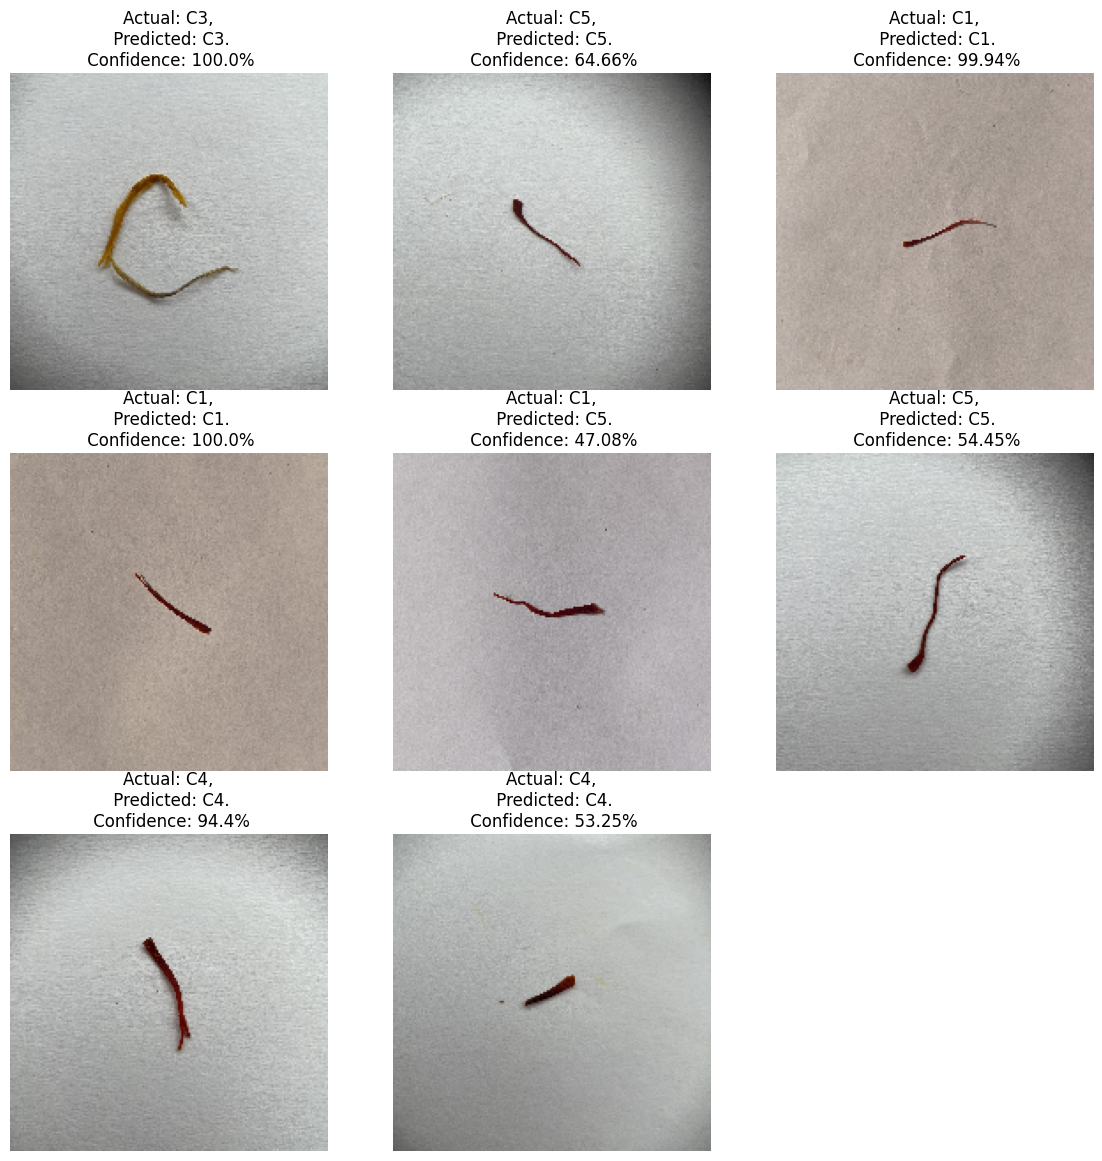

In [41]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [36]:
from IPython.display import display
from ipywidgets import FileUpload, VBox, Output
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import io

# Create an output widget to display the uploaded image
output_image = Output()

# Function to handle file upload, resize the image, and display it
def on_upload_change(change):
    uploaded_file = next(iter(uploader.value.values()))['content']
    img = PILImage.open(io.BytesIO(uploaded_file))  # Convert bytes to image

    # Resize the image to the size expected by the model
    img_resized = img.resize((IMAGE_SIZE, IMAGE_SIZE))

    with output_image:
        output_image.clear_output()  # Clear any previous output
        plt.figure(figsize=(4, 4))
        plt.imshow(img_resized)
        plt.axis("off")
        plt.show()

# Create the upload button
uploader = FileUpload(accept='image/*', multiple=False)
uploader.observe(on_upload_change, names='value')

# Display the upload button and output image
display(VBox([uploader, output_image]))

# Prompt to upload an image
print("Upload an image to display it here.")


Upload an image to display it here.


In [39]:
import numpy as np
import tensorflow as tf
from PIL import Image as PILImage
import io

# Function to make predictions on the resized image
def predict_resized_image():
    uploaded_file = next(iter(uploader.value.values()))['content']
    img = PILImage.open(io.BytesIO(uploaded_file))  # Convert bytes to image

    # Resize the image to the size expected by the model
    img_resized = img.resize((IMAGE_SIZE, IMAGE_SIZE))

    # Convert the image to an array and add a batch dimension
    img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    # Make predictions using the model
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

# Get the prediction for the resized image
predicted_class, confidence = predict_resized_image()

# Display the predicted class and confidence
if predicted_class == 'C1' or predicted_class == 'C2':
  print(f"The saffron strand is of pure saffron. It belongs to {predicted_class} class")
else:
  print(f"The saffron strand is of adulterated saffron. It belongs to {predicted_class} class")
print(f"Confidence: {confidence}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The saffron strand is of pure saffron. It belongs to C2 class
Confidence: 90.4%
